# ***PyMC2 - Final Project - Applied Statistics***

**Omer Shadmi (327722575) & Inbar Fabian (328274212)**

--------

## <u>**Theory:**</u>

As we've already seen, the grid search works well when the number of parameters is small. However, when the number of parameters increases, we find some problems with it. One of them is the curse of dimensionality.

1. <u>**Computational complexity**:</u> as we get to higher dimensions, the number of parameter combinations grows exponentially, making the grid search computationally infeasible. Because every dimension we add to the model adds another level of for-loops, the run time increases significantly (actually exponentially).

2. <u>**Problem with guessing support**:</u> For the grid method to work, you need to have a good idea of where the posterior distribution lies, or you end up missing important parts of the distribution.

3. <u>**Mass far from the mean**:</u> Most of the mass in high-dimensional spaces can lie far from the mean, making it hard to accurately capture the posterior with a simple grid. In contrast to lower dimensions, where the mass is more concentrated. Also known as the "curse of dimensionality".

We also don't necessary know how to calculate the normalizer in the bayes formula.


We may wanna try using rejection sampling, in which we calculate the posterior without knowing the normalizer, just using the prior and the likelihood, and then estimate the normalizer using sampling.
but actually it suffers from the same problems of grid search: we need to know a lot about the posterior distribution, and most of the mass is still far from the mean.


---------------

## <u>**MCMC:**</u>

In order to solve these problems, we will use MCMC, which is the worst way to do it but the only one that works.


**MCMC (Markov Chain Monte Carlo)** provides a powerful solution to the limitations of grid search and rejection sampling, especially in high-dimensional spaces. By using a Markov chain to explore the parameter space, MCMC allows us to approximate the posterior distribution without directly calculating the normalizer in Bayes’ theorem. This method generates samples from the posterior distribution by constructing a sequence of steps, each dependent only on the previous one, which gradually explores the high-probability regions.

Although MCMC does not guarantee a perfect solution, it is highly effective for complex models where traditional methods fail. However, MCMC can still face challenges such as poor mixing, which can lead to slow convergence and biased results. In this notebook, we'll explore these weaknesses and see how they can be addressed with specific techniques like reparameterization to improve the model's performance.

--------

## <u>**Prep:**</u>

We are going to use a dataset about covid. This dataset is a good example for the Simspon's Paradox. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

In [2]:
# Load the data
data = pd.read_csv("simpsons_paradox_covid.csv")

# Take a random sample to reduce dataset size and reset the index
df = data.sample(n=3000, random_state=42).reset_index(drop=True)

In [3]:
df.head()

,age_group,vaccine_status,outcome
0,50 +,vaccinated,survived
1,under 50,unvaccinated,survived
2,under 50,vaccinated,survived
3,under 50,unvaccinated,survived
4,under 50,vaccinated,survived


Convert to Numeric:

In [4]:
# Convert categorical variables to numeric
df['age_group'] = df['age_group'].map({'under 50': 0, '50 +': 1})
df['vaccine_status'] = df['vaccine_status'].map({'unvaccinated': 0, 'vaccinated': 1})
df['outcome'] = df['outcome'].map({'survived': 0, 'death': 1})

In [5]:
df.head()

,age_group,vaccine_status,outcome
0,1,1,0
1,0,0,0
2,0,1,0
3,0,0,0
4,0,1,0


-----

## <u>**Simpson's Paradox Demonstration:**</u>

We want to demonstrate the Simpson's Paradox as it shows in this covid dataset.

In [6]:
# Show the Simpson's Paradox
overall = df.groupby('vaccine_status')['outcome'].mean()
by_age = df.groupby(['age_group', 'vaccine_status'])['outcome'].mean().unstack()

# Rename the index and columns
overall.index = ['Unvaccinated', 'Vaccinated']
by_age.index = ['Under 50', '50+']
by_age.columns = ['Unvaccinated', 'Vaccinated']

Next, we can see that the death rate among unvaccinated people is higher than the vaccinated. 

But, when we seperate the dataset into age group, we will get different result. 

In [7]:
print("Overall death rate:")
display(overall)
print("\nDeath rate by age group:")
display(by_age)

Overall death rate:


,outcome
Unvaccinated,0.003531
Vaccinated,0.005380



Death rate by age group:


,Unvaccinated,Vaccinated
Under 50,0.000000,0.000000
50+,0.130435,0.021875


The death rate among vaccinated people who are older than 50 - is much lower!

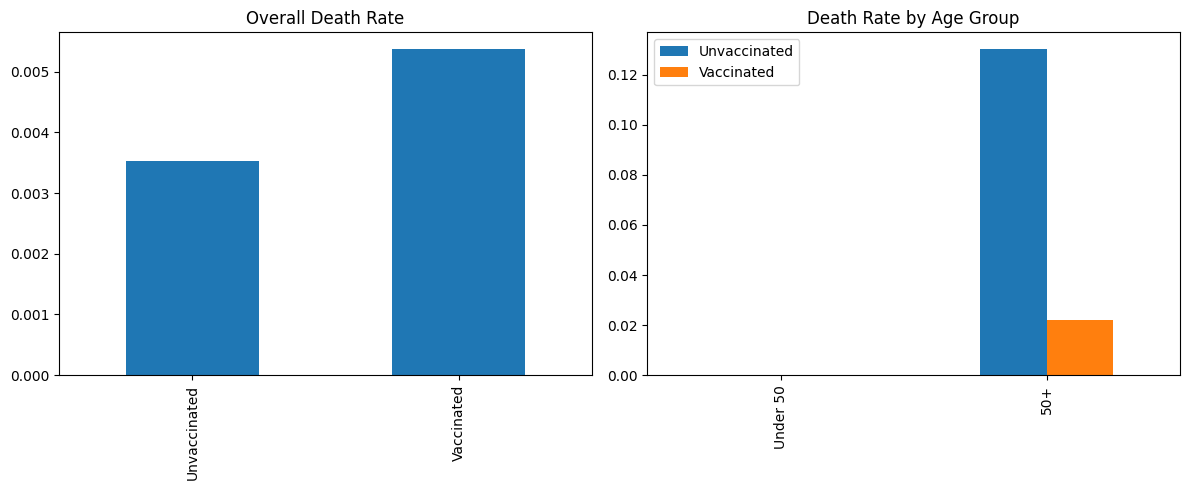

In [8]:
# Visualize the paradox
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
overall.plot(kind='bar', ax=ax1, title='Overall Death Rate')
by_age.plot(kind='bar', ax=ax2, title='Death Rate by Age Group')
plt.tight_layout()
plt.show()

We can see this effect more cleary in this plot. 

At first, it seems like the unvaccinated died in lower rates, but when we zoom in the picture is different.

---------

## <u>**Poor Model:**</u>

We are going to apply this initial model on our dataset, and see if it's able to capture the nuances we've talked about. 

We will go with centered parameterization. And see what are the 'weaknesses' of the MCMC method.

In [9]:
with pm.Model() as initial_model:
    # Hyperpriors
    alpha_mu = pm.Normal("alpha_mu", 0, sigma=1)
    alpha_sigma = pm.HalfNormal("alpha_sigma", sigma=1)
    beta_vaccine_mu = pm.Normal("beta_vaccine_mu", 0, sigma=1)
    beta_vaccine_sigma = pm.HalfNormal("beta_vaccine_sigma", sigma=1)
    beta_age_mu = pm.Normal("beta_age_mu", 0, sigma=1)
    beta_age_sigma = pm.HalfNormal("beta_age_sigma", sigma=1)

    # Group-level parameters
    alpha = pm.Normal("alpha", alpha_mu, sigma=alpha_sigma, shape=2)  # One for each age group
    beta_vaccine = pm.Normal("beta_vaccine", beta_vaccine_mu, sigma=beta_vaccine_sigma, shape=2)  # One for each age group

    # Linear model
    logit_p = alpha[df['age_group'].astype(int)] + beta_vaccine[df['age_group'].astype(int)] * df['vaccine_status'] + beta_age_mu * df['age_group']

    # Likelihood
    y = pm.Bernoulli("y", logit_p=logit_p, observed=df['outcome'])

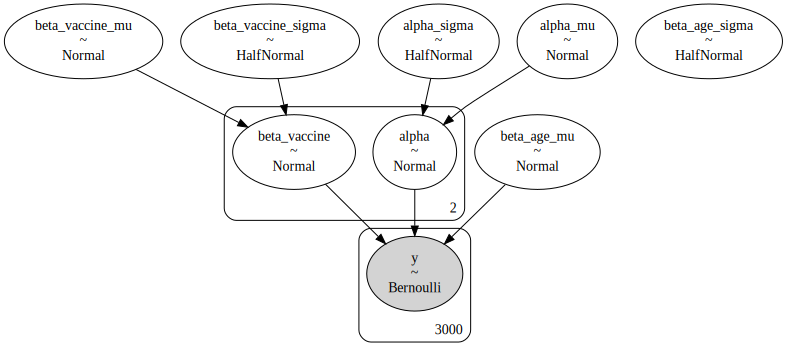

In [10]:
# Visualize model graph
pm.model_to_graphviz(initial_model)

In [11]:
# Sampling
with initial_model:
    idata_initial = pm.sample(1000, chains=2, return_inferencedata=True)

Output()

Output()

ERROR:pymc.stats.convergence:There were 544 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Divergence in first chain: **34**

Divergence in second chain: **510**

We can see that we have a lot of divergences. This can happen do to our centered parameterization, which can cause a 'funnel shape' posterior, and the MCMC kind of 'stuck' in it. 

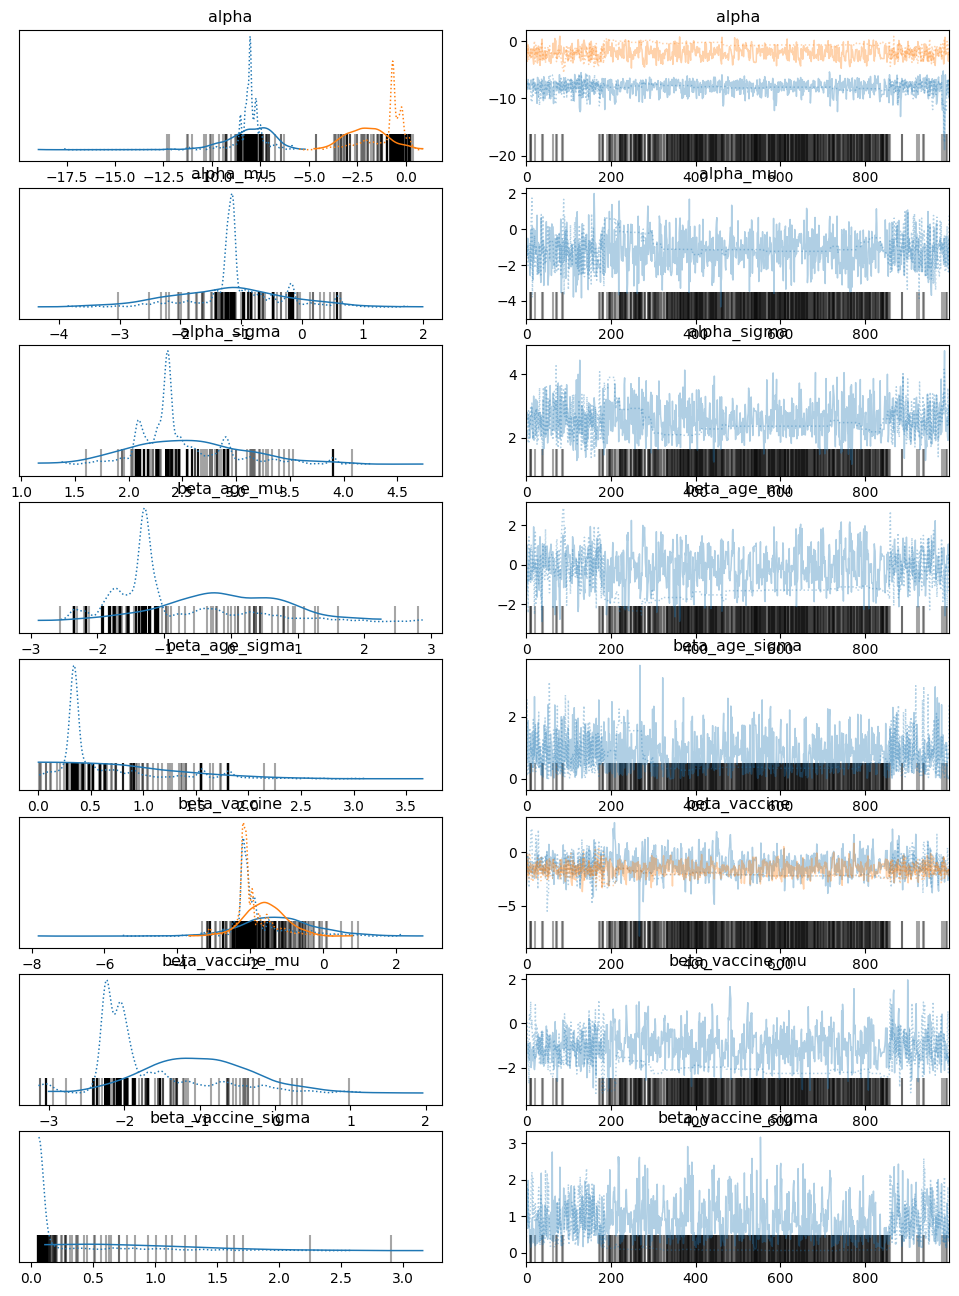

In [12]:
# Evaluate the poor model
az.plot_trace(idata_initial);

We can see how badly are the differences between the chains - indicating that the model wasn't able to learn it right. We can also see that the model is getting stuck a lot in this example. 

In [14]:
# See the bad model performence
az.summary(idata_initial, var_names=['alpha', 'beta_vaccine', 'beta_age_mu', 'alpha_sigma', 'beta_vaccine_sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-8.081,1.084,-10.090,-6.210,0.039,0.030,389.0,650.0,1.13
alpha[1],-1.509,1.141,-3.564,0.226,0.385,0.282,10.0,149.0,1.15
beta_vaccine[0],-1.505,0.990,-3.170,0.528,0.209,0.150,18.0,206.0,1.08
beta_vaccine[1],-1.768,0.567,-2.572,-0.408,0.134,0.096,15.0,182.0,1.09
beta_age_mu,-0.570,1.021,-2.350,1.171,0.339,0.248,9.0,48.0,1.16
alpha_sigma,2.525,0.493,1.681,3.563,0.040,0.030,175.0,273.0,1.11
beta_vaccine_sigma,0.620,0.591,0.059,1.734,0.208,0.153,5.0,8.0,1.30


High R-hat values, and very low ESS-bulk values, which indicate bad mixing of the MCMC.

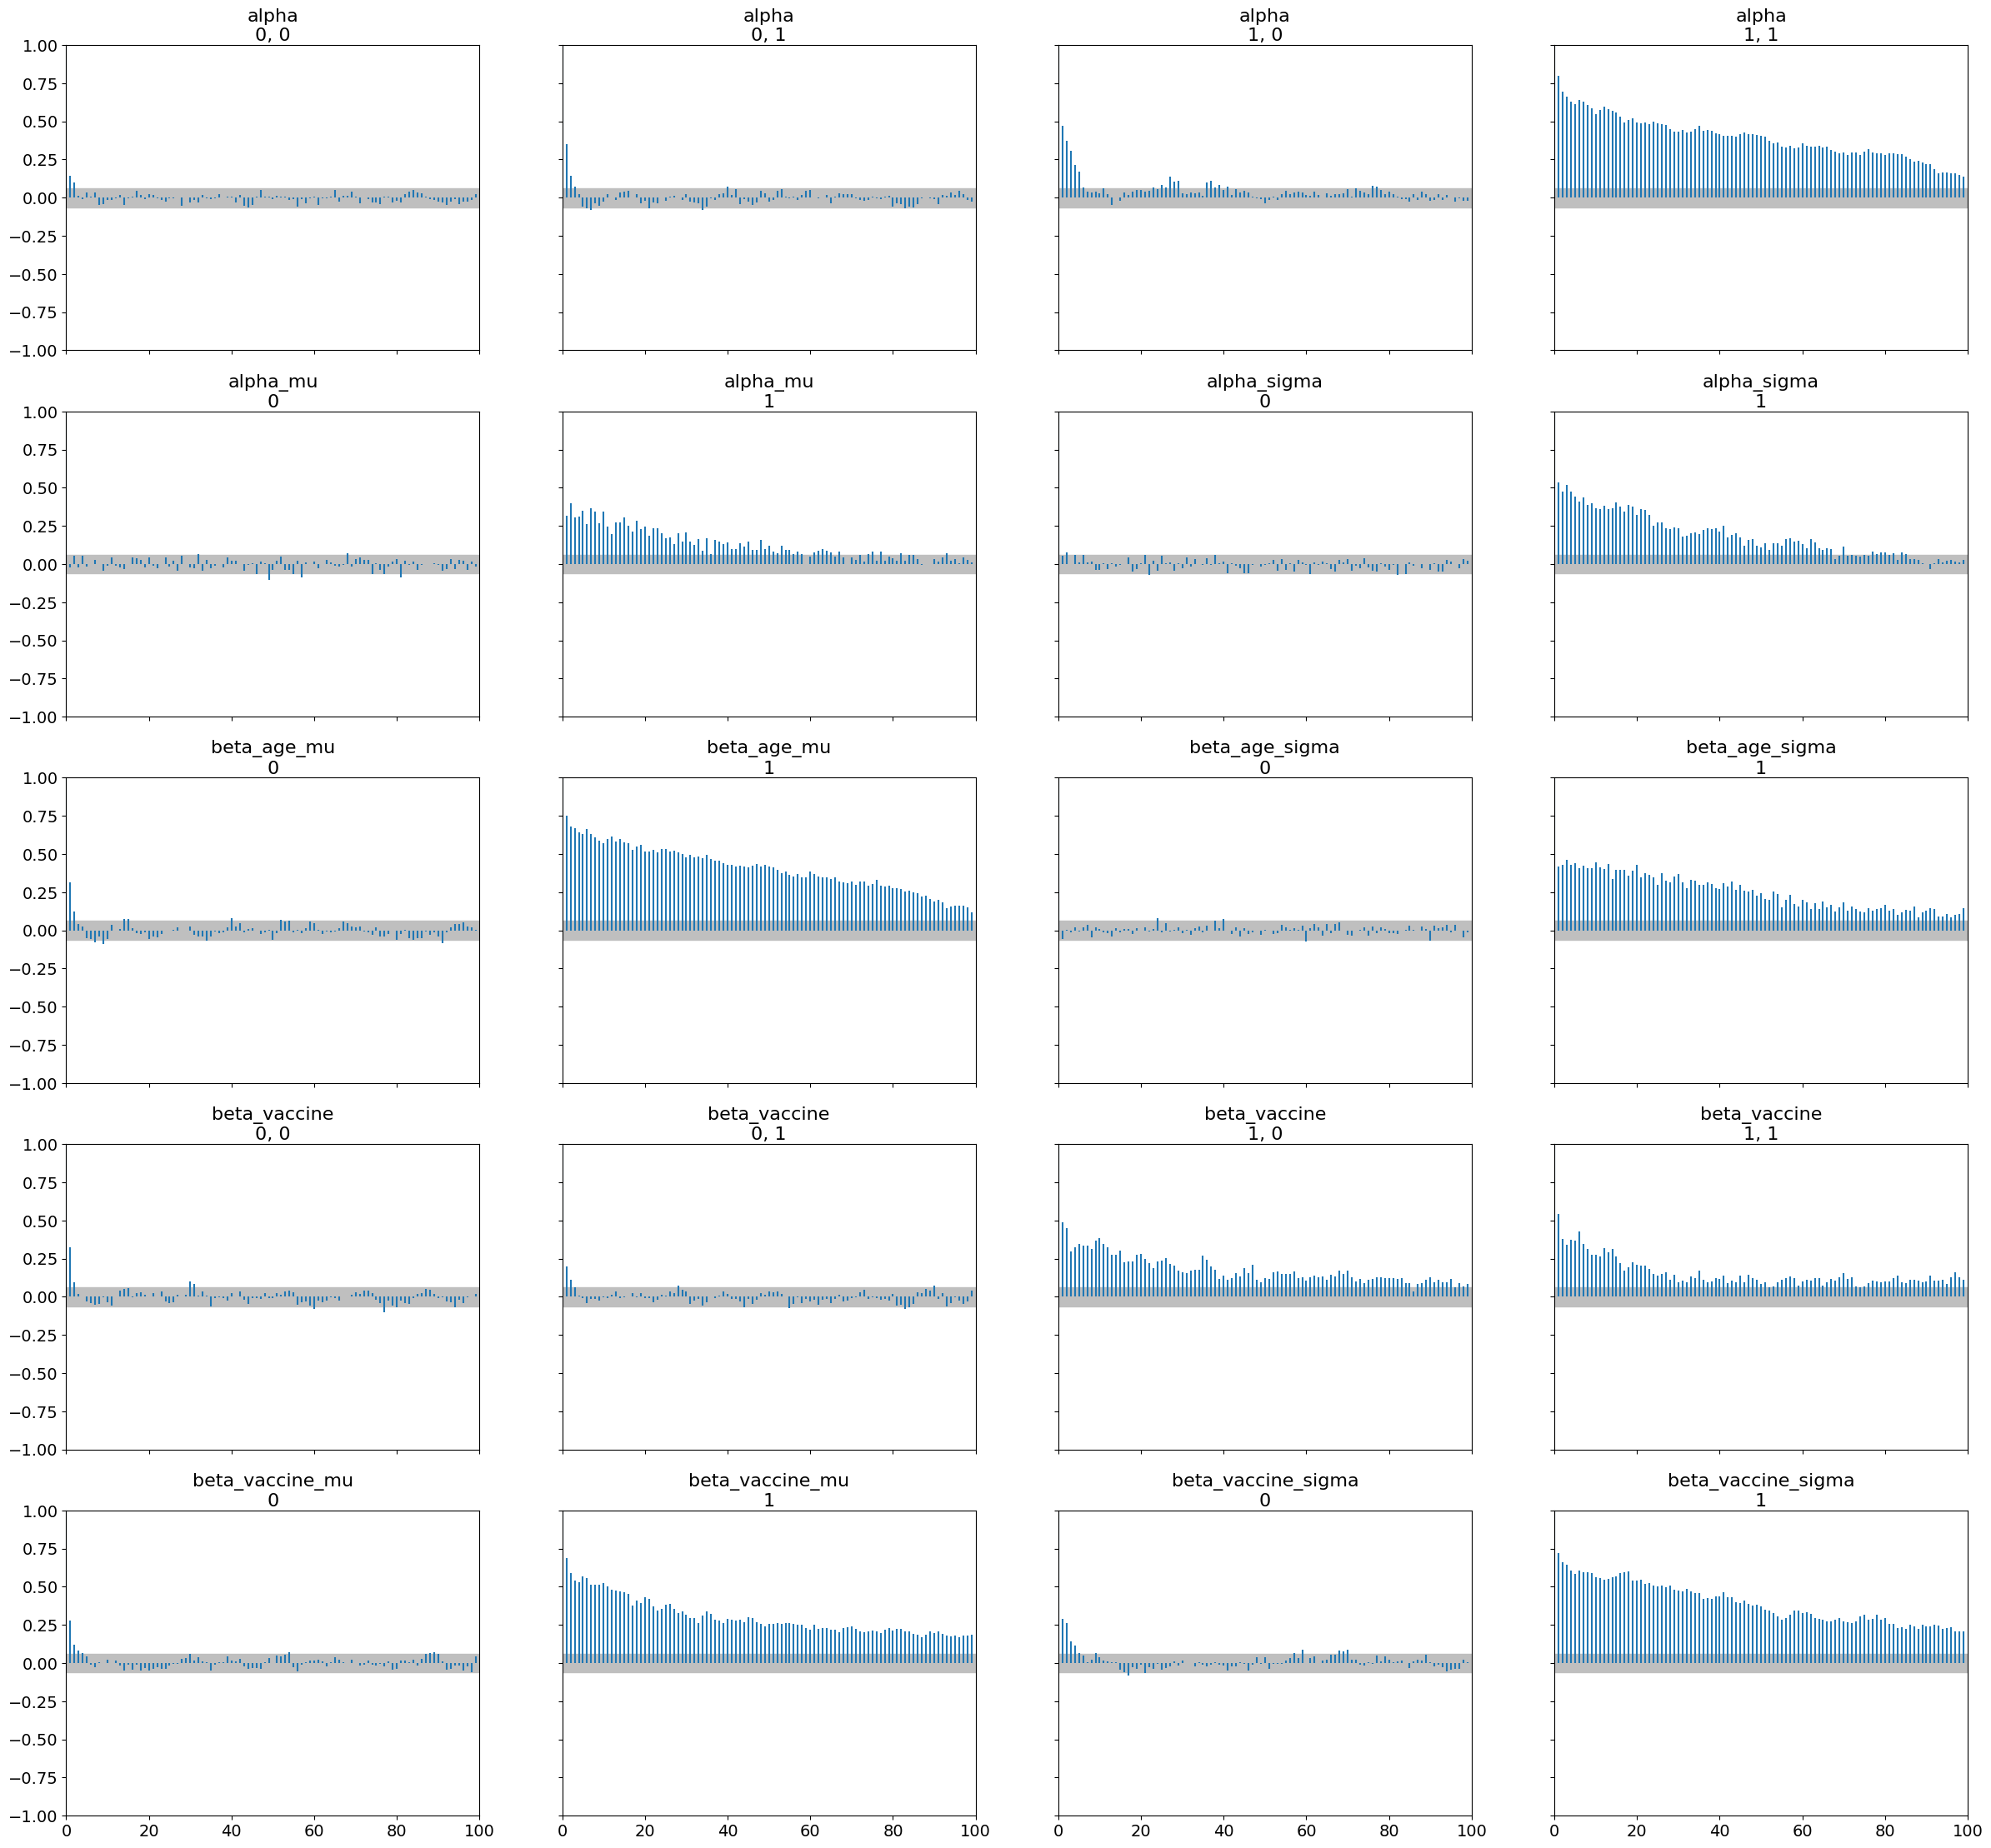

In [17]:
# Autocorrelation plot for the bad model
az.plot_autocorr(idata_initial);

We see very problematic autocorrelation patterns. 

----

## <u>**Long Model:**</u>

Now, we move to talk about the strategies to fix the poor mixing of the MCMC. 

1. The first method is simply: letting the chain to run for longer. 

We will try letting the chains run for 5000 samples (instead of just 1000).

In [46]:
# Running the same model for a longer chain
with initial_model:
    idata_long = pm.sample(5000, chains=2)

Output()

Output()

ERROR:pymc.stats.convergence:There were 794 divergences after tuning. Increase `target_accept` or reparameterize.


Divergence in first chain: **427**

Divergence in second chain: **367**

We still have a lot of divergences, but it's much less compared to the initial model, considering that we now have much more samples (10,000 vs. 2000)

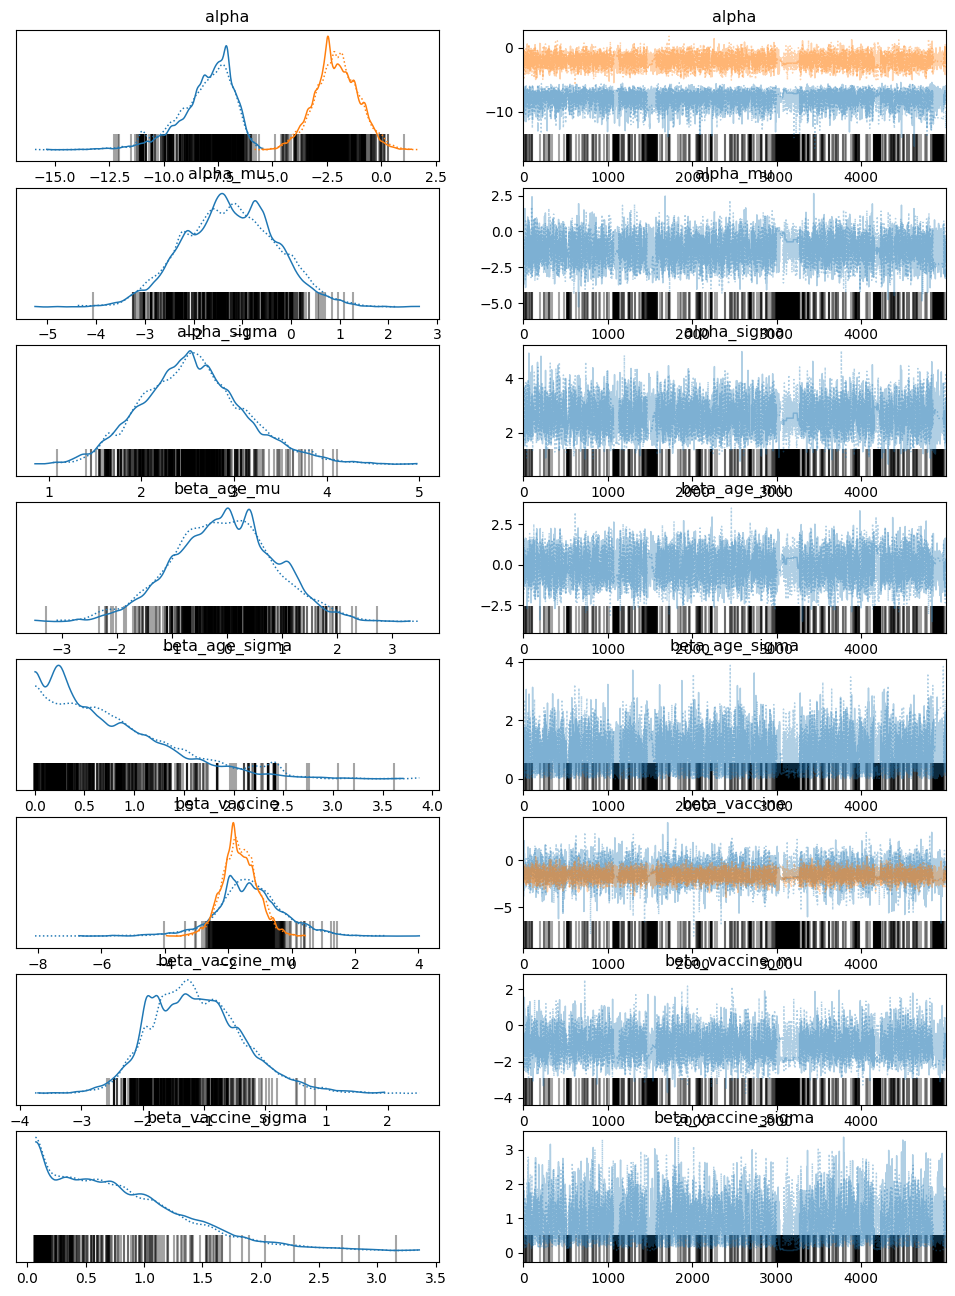

In [47]:
# Evaluate the longer chain
az.plot_trace(idata_long);

The harmony between the chains isn't perfect, but it's much better than before.

In [48]:
# Summary for the long model
az.summary(idata_long, var_names=['alpha', 'beta_vaccine', 'beta_age_mu', 'alpha_sigma', 'beta_vaccine_sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-8.066,1.275,-10.521,-5.960,0.055,0.040,656.0,407.0,1.01
alpha[1],-2.050,1.000,-3.973,-0.190,0.016,0.012,3703.0,4535.0,1.00
beta_vaccine[0],-1.318,1.081,-3.193,1.031,0.018,0.013,2890.0,3927.0,1.00
beta_vaccine[1],-1.634,0.545,-2.594,-0.561,0.011,0.008,2324.0,3863.0,1.00
beta_age_mu,-0.065,0.924,-1.767,1.717,0.016,0.012,3182.0,4491.0,1.00
alpha_sigma,2.565,0.560,1.508,3.608,0.010,0.007,2944.0,1161.0,1.00
beta_vaccine_sigma,0.818,0.570,0.065,1.833,0.024,0.017,251.0,92.0,1.01


We can also see much lower R-hat values, which is good. And much higher ESS-bulk values, which is also good. 

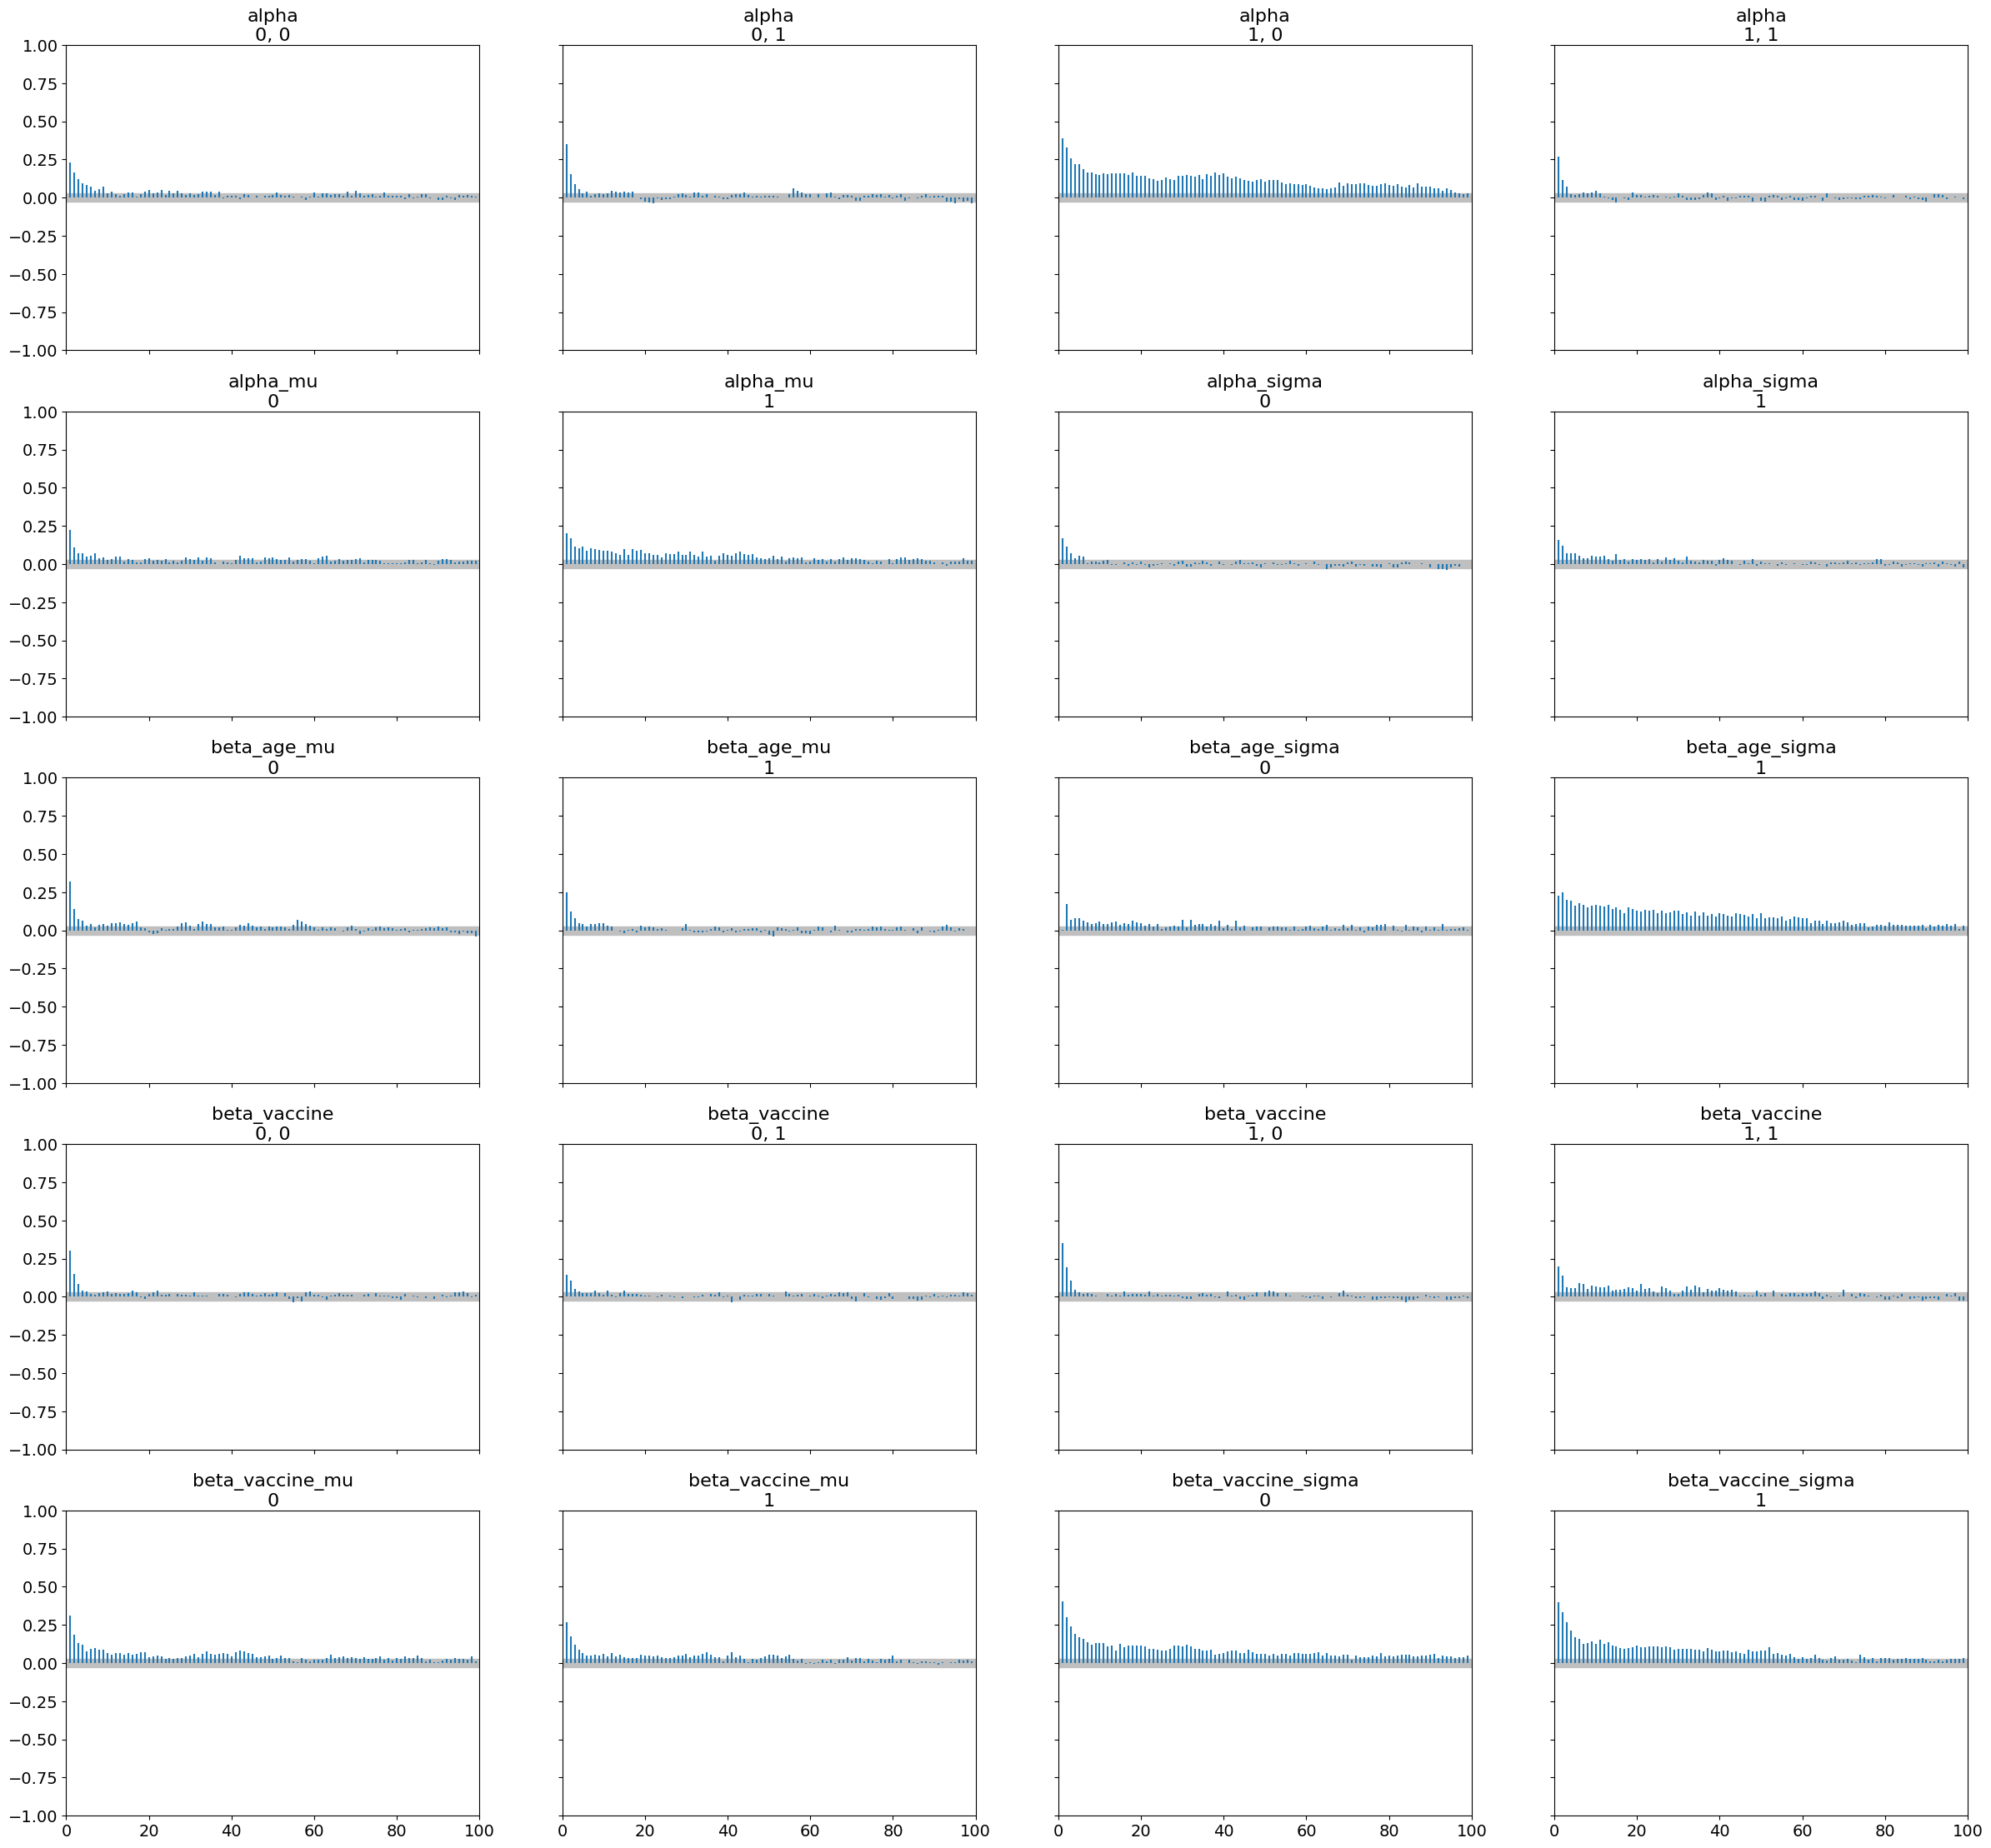

In [49]:
# Autocorrelation plot for the long model
az.plot_autocorr(idata_long);

The autocorrelations between our paramter now are still problematic, but there is a significant improvment from the initial model.

--------

## <u>**Reparameterized Model:**</u>

2. The second method is reparameterizing the model

We will use non-centered parameters this time, and see how it affect the model's performence. 

In [25]:
with pm.Model() as reparam_model:
    # Hyperpriors
    alpha_mu = pm.Normal("alpha_mu", 0, sigma=1)
    alpha_sigma = pm.HalfNormal("alpha_sigma", sigma=1)
    beta_vaccine_mu = pm.Normal("beta_vaccine_mu", 0, sigma=1)
    beta_vaccine_sigma = pm.HalfNormal("beta_vaccine_sigma", sigma=1)
    beta_age_mu = pm.Normal("beta_age_mu", 0, sigma=1)
    beta_age_sigma = pm.HalfNormal("beta_age_sigma", sigma=1)

    # Non-centered parameterization
    alpha_offset = pm.Normal("alpha_offset", 0, sigma=1, shape=2)
    alpha = pm.Deterministic("alpha", alpha_mu + alpha_offset * alpha_sigma)

    beta_vaccine_offset = pm.Normal("beta_vaccine_offset", 0, sigma=1, shape=2)
    beta_vaccine = pm.Deterministic("beta_vaccine", beta_vaccine_mu + beta_vaccine_offset * beta_vaccine_sigma)

    # Linear model
    logit_p = alpha[df['age_group'].astype(int)] + beta_vaccine[df['age_group'].astype(int)] * df['vaccine_status'] + beta_age_mu * df['age_group']

    # Likelihood
    y = pm.Bernoulli("y", logit_p=logit_p, observed=df['outcome'])

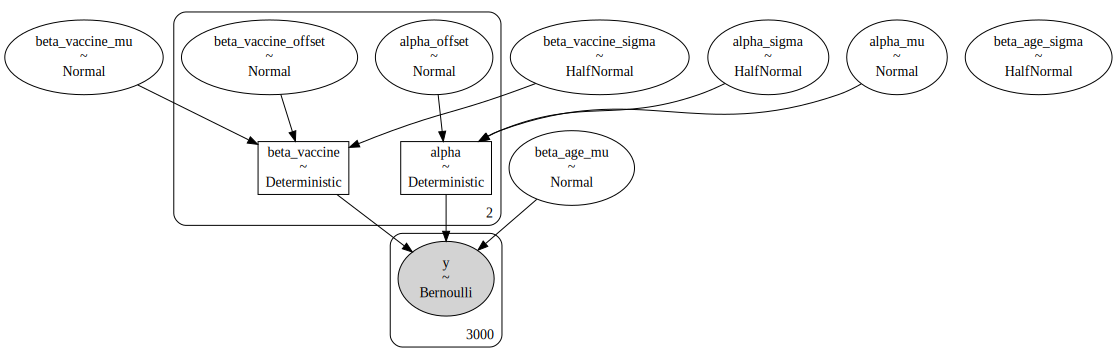

In [26]:
# Visualize improved model graph
pm.model_to_graphviz(reparam_model)

In [27]:
# Sampling
with reparam_model:
    idata_reparam = pm.sample(1000, chains=2, return_inferencedata=True)

Output()

Output()

ERROR:pymc.stats.convergence:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


Divergence in first chain: **5**

Divergence in second chain: **0**

Wow! We have a very small amount of divergences this time!

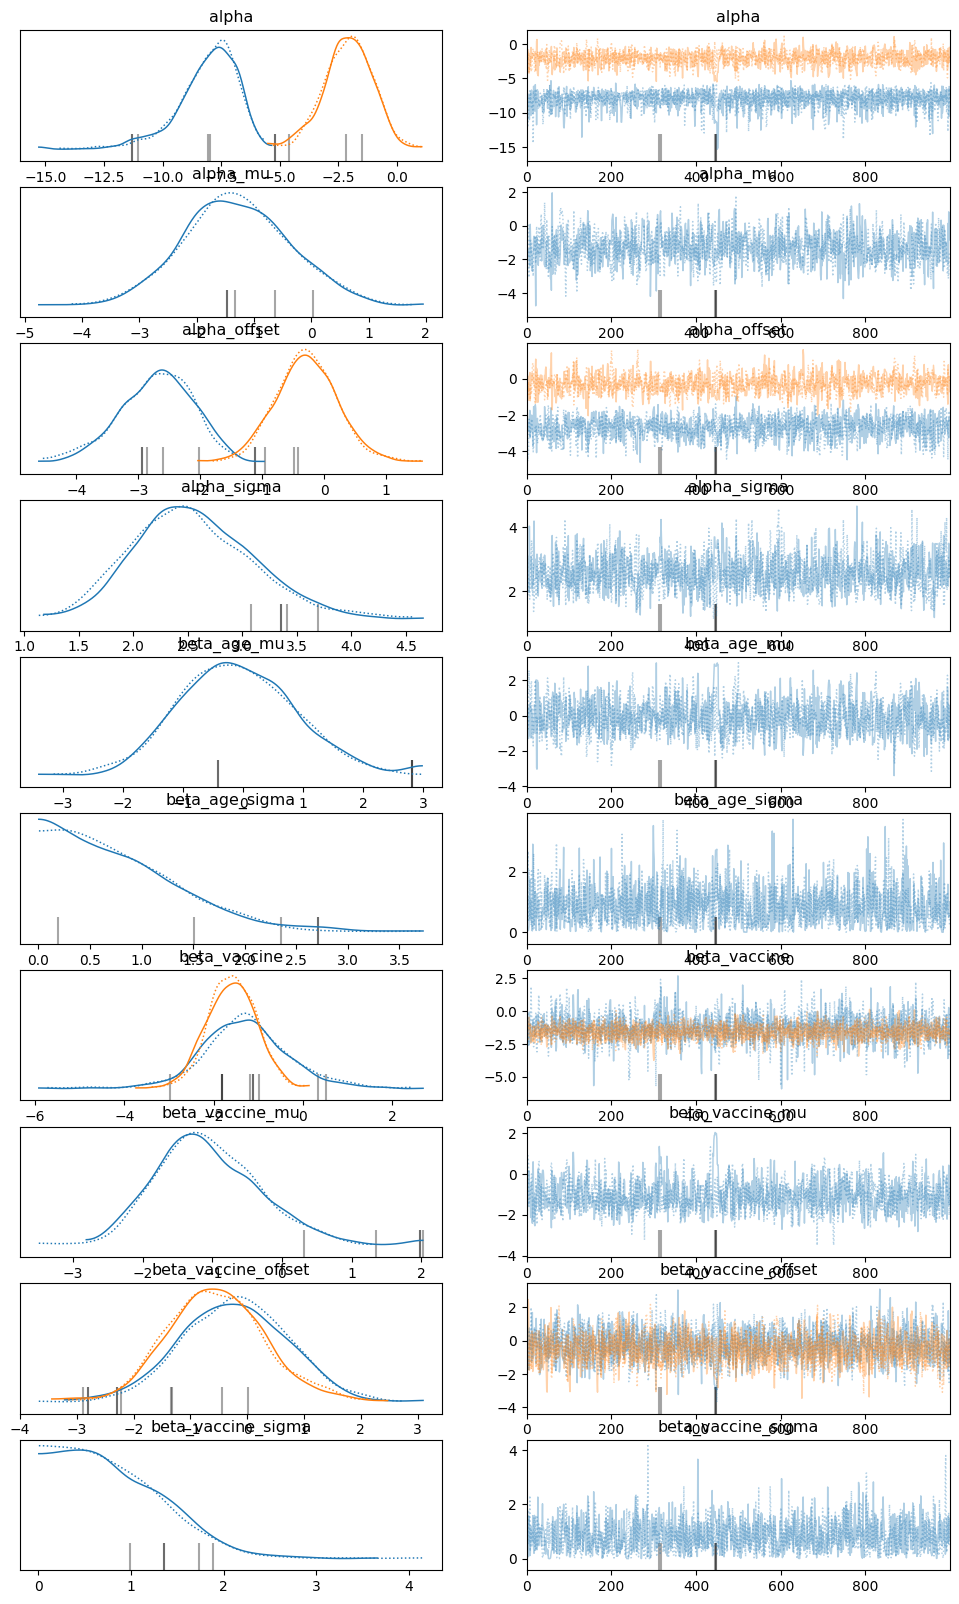

In [28]:
# Evaluate the improved model
az.plot_trace(idata_reparam);

Now the samplings of both chains are very good. 

In [29]:
# Summary of the improved model
az.summary(idata_reparam, var_names=['alpha', 'beta_vaccine', 'beta_age_mu', 'alpha_sigma', 'beta_vaccine_sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-8.082,1.297,-10.474,-5.883,0.034,0.026,2006.0,982.0,1.0
alpha[1],-2.070,1.040,-4.106,-0.275,0.035,0.027,936.0,723.0,1.0
beta_vaccine[0],-1.292,1.032,-3.104,0.884,0.027,0.019,1536.0,1476.0,1.0
beta_vaccine[1],-1.587,0.547,-2.607,-0.590,0.011,0.008,2476.0,1579.0,1.0
beta_age_mu,-0.093,0.966,-1.911,1.658,0.032,0.028,936.0,703.0,1.0
alpha_sigma,2.555,0.547,1.588,3.607,0.017,0.012,1088.0,1153.0,1.0
beta_vaccine_sigma,0.810,0.567,0.000,1.761,0.016,0.011,918.0,586.0,1.0


low R-hat values and high ESS-bulk values - very good. 

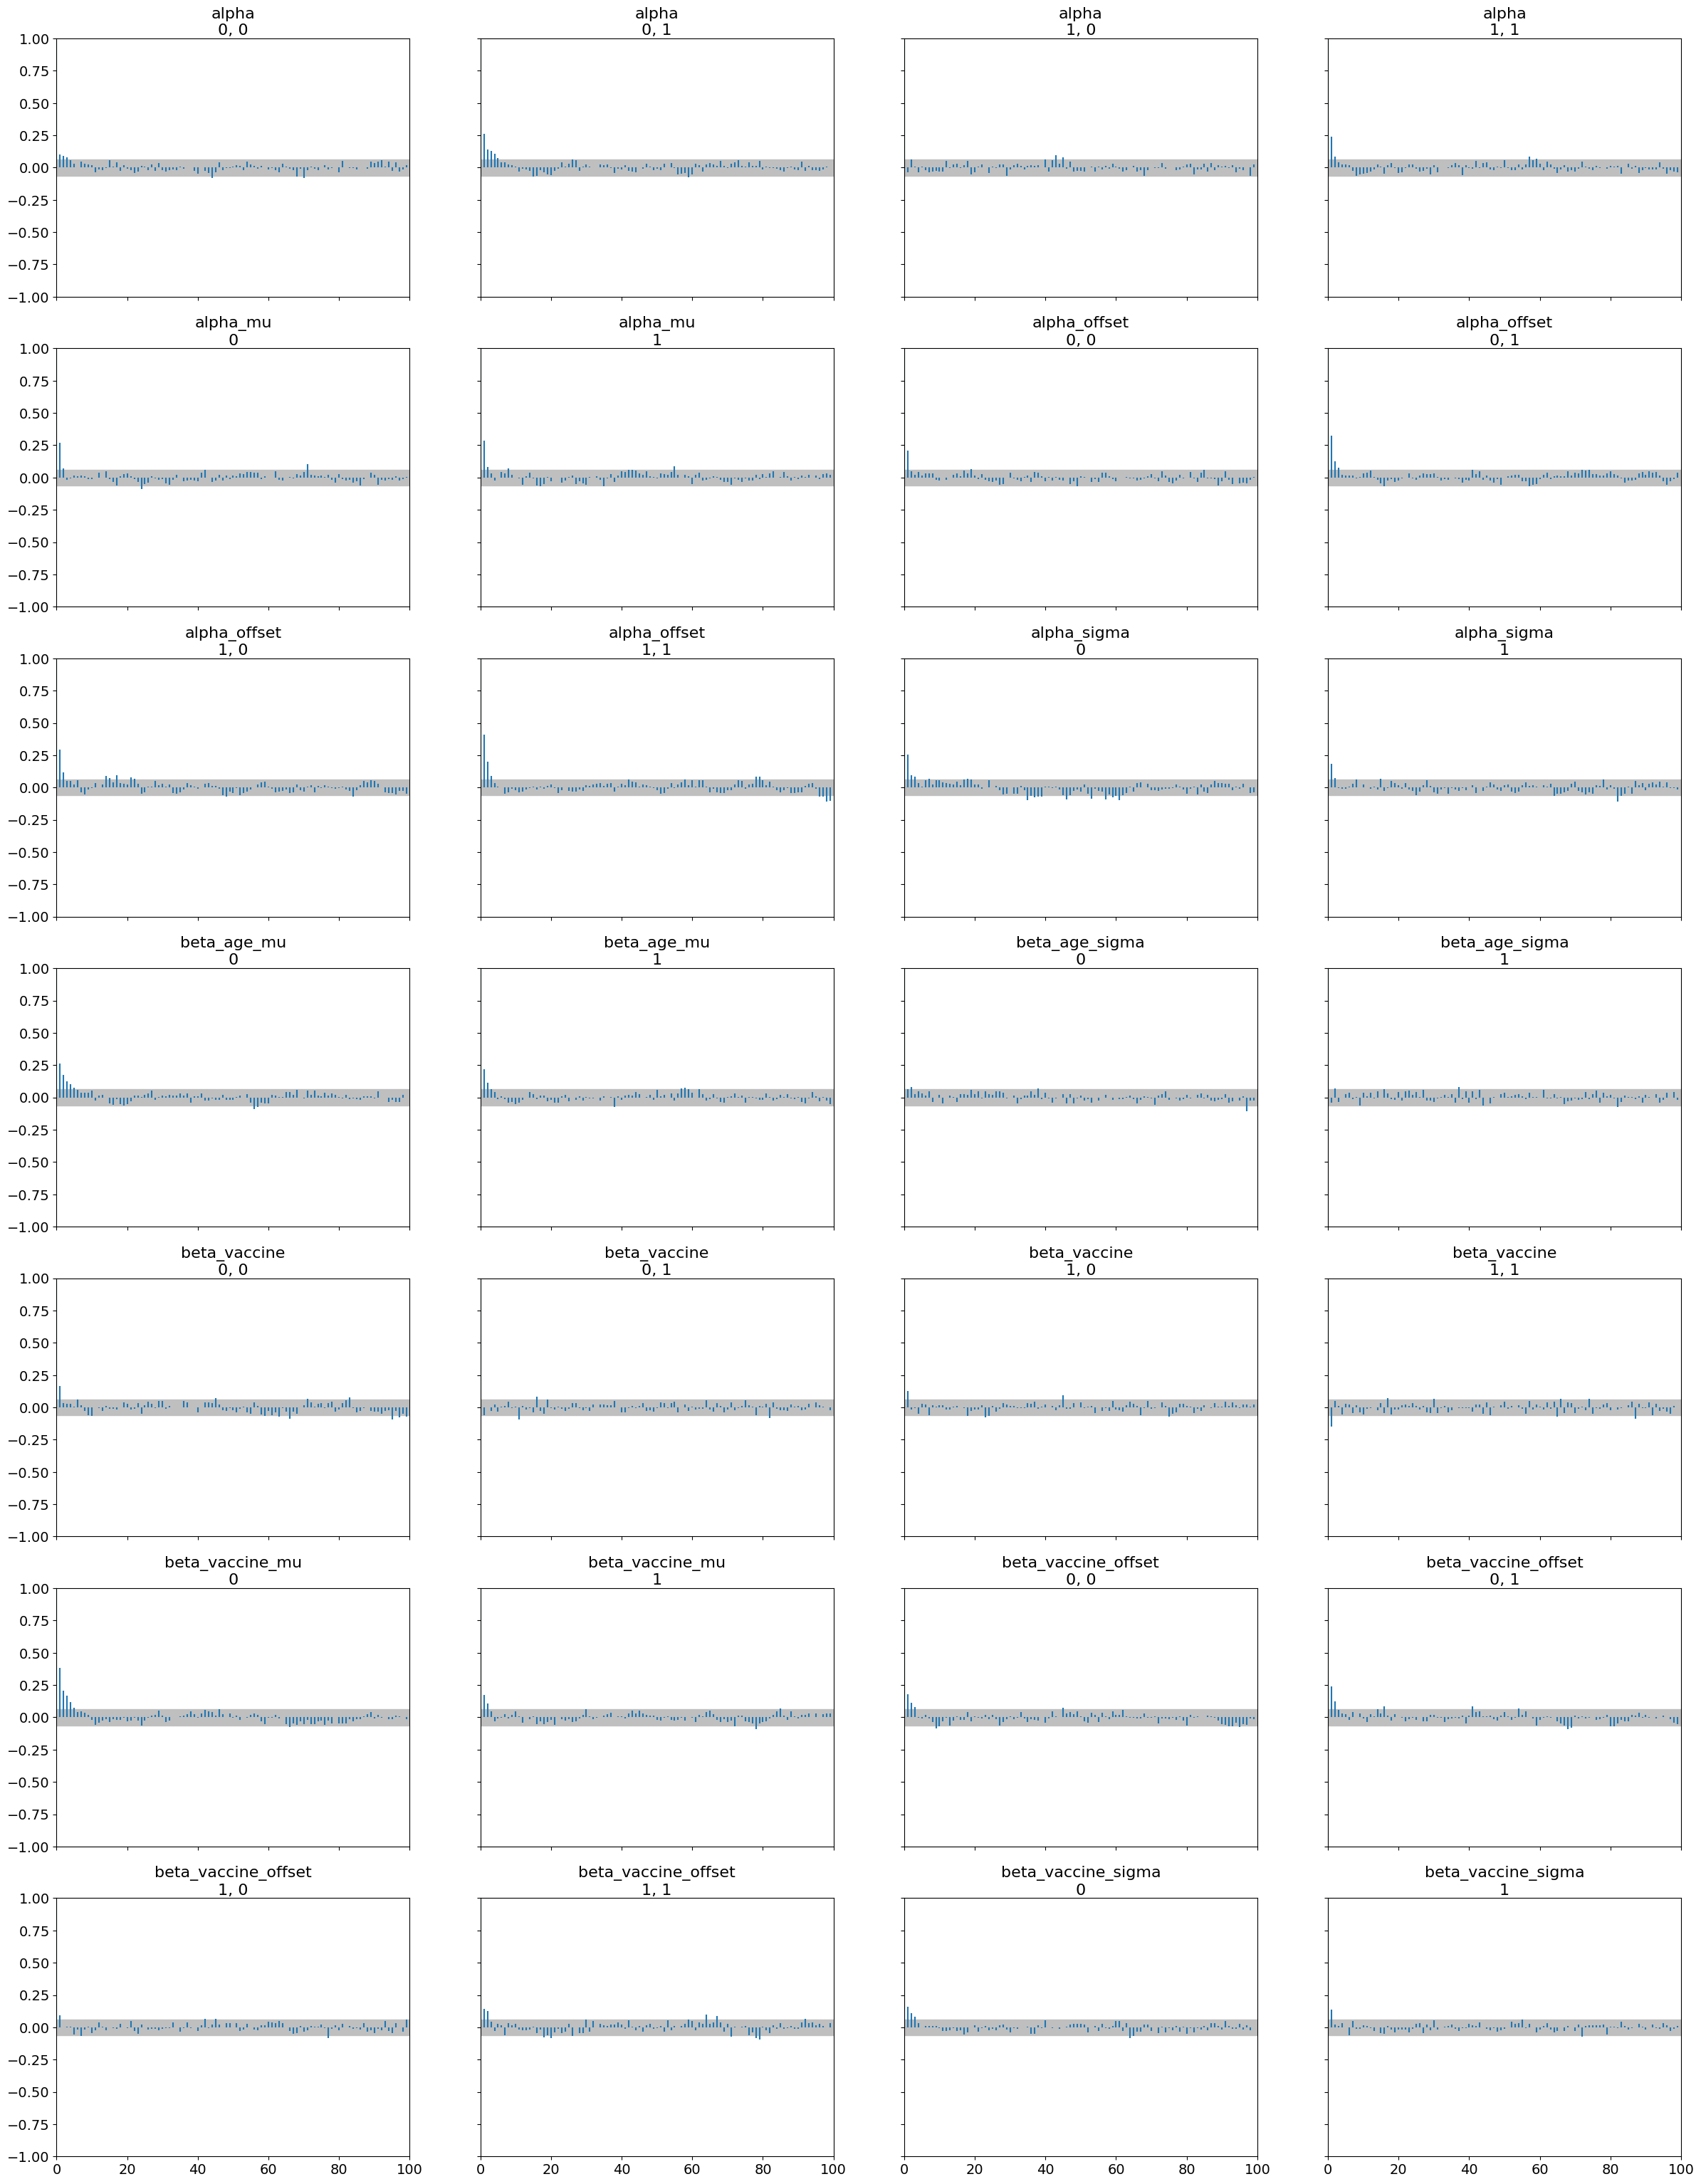

In [45]:
# Autocorrelation plot for the reparameterized model
az.plot_autocorr(idata_reparam);

And also the autocorrelations now are very low - which is good.

-------

## <u>**Comparisons:**</u>

Let's compare our different models!

### **Divergences**

In [51]:
# Compare divergences
initial_divergences = idata_initial.sample_stats.diverging.sum().item()
long_divergences = idata_long.sample_stats.diverging.sum().item()
reparam_divergences = idata_reparam.sample_stats.diverging.sum().item()

print("Divergences:")
print(f"Poor model: {initial_divergences}")
print(f"Long model: {long_divergences}")
print(f"Improved model: {reparam_divergences}")

# Compare the total number of samples
initial_samples = idata_initial.sample_stats.diverging.size
long_samples = idata_long.sample_stats.diverging.size
reparam_samples = idata_reparam.sample_stats.diverging.size

print(f"\nTotal samples:")
print(f"Poor model: {initial_samples}")
print(f"Long model: {long_samples}")
print(f"Improved model: {reparam_samples}")

# Calculate divergence rates
initial_rate = (initial_divergences / initial_samples) * 100
long_rate = (long_divergences / long_samples) * 100
reparam_rate = (reparam_divergences / reparam_samples) * 100

print(f"\nDivergence rates:")
print(f"Poor model: {initial_rate:.2f}%")
print(f"Long model: {long_rate:.2f}%")
print(f"Improved model: {reparam_rate:.2f}%")

Divergences:
Poor model: 544
Long model: 794
Improved model: 5

Total samples:
Poor model: 2000
Long model: 10000
Improved model: 2000

Divergence rates:
Poor model: 27.20%
Long model: 7.94%
Improved model: 0.25%


### **R-hat values**

In [52]:
# Compare R-hat values
poor_rhat = az.summary(idata_initial)['r_hat'].max()
long_rhat = az.summary(idata_long)['r_hat'].max()
improved_rhat = az.summary(idata_reparam)['r_hat'].max()

print(f"\nMaximum R-hat values:")
print(f"Poor model: {poor_rhat:.3f}")
print(f"Long model: {long_rhat:.3f}")
print(f"Improved model: {improved_rhat:.3f}")


Maximum R-hat values:
Poor model: 1.300
Long model: 1.010
Improved model: 1.000


### **ESS (bulk) values**

In [53]:
# Compare ESS (bulk) values
poor_ess_bulk = az.summary(idata_initial)['ess_bulk'].min()
long_ess_bulk = az.summary(idata_long)['ess_bulk'].min()
improved_ess_bulk = az.summary(idata_reparam)['ess_bulk'].min()

print(f"\nMinimum ESS (bulk) values:")
print(f"Poor model: {poor_ess_bulk:.1f}")
print(f"Long model: {long_ess_bulk:.1f}")
print(f"Improved model: {improved_ess_bulk:.1f}")

# Compare mean ESS (bulk)
poor_mean_ess_bulk = az.summary(idata_initial)['ess_bulk'].mean()
long_mean_ess_bulk = az.summary(idata_long)['ess_bulk'].mean()
improved_mean_ess_bulk = az.summary(idata_reparam)['ess_bulk'].mean()

print(f"\nMean ESS (bulk) values:")
print(f"Poor model: {poor_mean_ess_bulk:.1f}")
print(f"Long model: {long_mean_ess_bulk:.1f}")
print(f"Improved model: {improved_mean_ess_bulk:.1f}")


Minimum ESS (bulk) values:
Poor model: 5.0
Long model: 251.0
Improved model: 877.0

Mean ESS (bulk) values:
Poor model: 89.9
Long model: 1891.4
Improved model: 1244.1


---------

## <u>**Conclusion:**</u>

We've tried two different methods to solve the problem of bad MCMC mixing:
1. Running the chain for longer. 
2. Reparameterization.

In conclusion, in our very extreme exmple, the reparameterization oprion gave us better results, and fixed the problem. 

**The End!**

---------